# Data Challenge 4b

## Download data

In [1]:
#! pip install -q lalsuite
#! pip install -q gwpy
#! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

--2022-05-27 18:19:42--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  5.05MB/s    in 54s     

2022-05-27 18:20:37 (4.50 MB/s) - ‘challenge3.gwf’ saved [256815066/256815066]



## Simple-To-Use matched-filtering code from sample

In [2]:
from pycbc import frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr

import numpy

import pylab
%matplotlib inline

def challenge_matched_filter(file_name,channel_name,mass):
    print("Looking at file {} with template mass {} M_sol".format(file_name,mass))
    #start = 0
    #end = start + 128
    #ts = read_frame(file_name, channel_name, start, end)
    ts = frame.read_frame(file_name, channel_name)
    ts = highpass(ts, 15.0)
    strain_ts = resample_to_delta_t(ts, 1.0/2048)
    conditioned_ts = strain_ts.crop(2, 2)
    psd_ts = conditioned_ts.psd(16)
    psd_ts = interpolate(psd_ts, conditioned_ts.delta_f)
    psd_ts = inverse_spectrum_truncation(psd_ts, int(4 * conditioned_ts.sample_rate),low_frequency_cutoff=15)
    
    hp_x, _ = get_fd_waveform(approximant="IMRPhenomD",
                                mass1=mass, mass2=mass,
                                f_lower=20.0, delta_f=conditioned_ts.delta_f)
    hp_x.resize(len(psd_ts))

    # For each observatory use this template to calculate the SNR time series
    snr_x = matched_filter(hp_x, conditioned_ts, psd=psd_ts, low_frequency_cutoff=20).crop(5, 4)

    #pylab.figure(figsize=[14, 4])
    #pylab.plot(snr_x.sample_times, abs(snr_x), label='H1')
    #pylab.title('SNR Time Series')
    #pylab.grid()
    #pylab.xlabel('Time (s)')
    #pylab.ylabel('Signal-to-noise (SNR)')
    #pylab.show()
    
    #peak_x = numpy.argmax(abs(snr_x))
    #snr_x_peak = snr_x[peak_x]
    #time_x = snr_x.sample_times[peak_x]
    #print("We found a possible signal at {}s with SNR {}".format(time_x, abs(snr_x_peak)))

    chisq_x = {}
    nbins = 26
    chisq_x = power_chisq(hp_x, conditioned_ts, nbins, psd_ts, low_frequency_cutoff=20.0)
    chisq_x = chisq_x.crop(5, 4)

    dof_x = nbins * 2 - 2
    chisq_x /= dof_x


    # The rho-hat term above is named "newsnr" here
    nsnr_x = newsnr(abs(snr_x), chisq_x)

    peak_x = numpy.argmax(abs(nsnr_x))
    nsnr_x_peak = nsnr_x[peak_x]
    time_x = snr_x.sample_times[peak_x]
    
    nsnr_out = nsnr_x_peak
    time_out = time_x
    
    #print("We found a signal at {}s with (reweighed) SNR {}".format(time_x, abs(nsnr_x_peak)))
    #Plot the new SNR timeseries
    #pylab.figure(figsize=[14, 4])
    #pylab.plot(snr_x.sample_times, nsnr_x, label='H1')
    #pylab.title('NewSNR Timeseries')
    #pylab.grid()
    #pylab.xlabel('Time (s)')
    #pylab.ylabel('Re-weighted Signal-to-noise')
    #pylab.show()
    
    return nsnr_out, time_out

### Using loop to search for mass

In [3]:
file = 'challenge3.gwf'
channel = 'H1:CHALLENGE3'
#channel = 'L1:CHALLENGE3'

In [4]:
import numpy
snr_threshold = 8.0
n = 41
m = []
s = []
t = []
for mass in numpy.array([20/(n-1)*i+10 for i in range(n)]):
    nsnr_x_peak_out, time_x_out = challenge_matched_filter(file,channel, mass)
    if nsnr_x_peak_out >= snr_threshold:
        m.append(mass)
        s.append(nsnr_x_peak_out)
        t.append(time_x_out)
        print("SNR {} > {} at mass {}".format(nsnr_x_peak_out, snr_threshold, mass))

Looking at file challenge3.gwf with template mass 10.0 M_sol
SNR 26.870953418426634 > 8.0 at mass 10.0
Looking at file challenge3.gwf with template mass 10.5 M_sol
Looking at file challenge3.gwf with template mass 11.0 M_sol
Looking at file challenge3.gwf with template mass 11.5 M_sol
Looking at file challenge3.gwf with template mass 12.0 M_sol
Looking at file challenge3.gwf with template mass 12.5 M_sol
Looking at file challenge3.gwf with template mass 13.0 M_sol
Looking at file challenge3.gwf with template mass 13.5 M_sol
Looking at file challenge3.gwf with template mass 14.0 M_sol
Looking at file challenge3.gwf with template mass 14.5 M_sol
Looking at file challenge3.gwf with template mass 15.0 M_sol
Looking at file challenge3.gwf with template mass 15.5 M_sol
Looking at file challenge3.gwf with template mass 16.0 M_sol
Looking at file challenge3.gwf with template mass 16.5 M_sol
SNR 9.528067869876283 > 8.0 at mass 16.5
Looking at file challenge3.gwf with template mass 17.0 M_sol
SN

In [7]:
import numpy
snr_threshold = 10.0
n = 20
for mass in numpy.array([19/(n-1)*i+31 for i in range(n)]):
    nsnr_x_peak_out, time_x_out = challenge_matched_filter(file,channel, mass)
    if nsnr_x_peak_out >= snr_threshold:
        m.append(mass)
        s.append(nsnr_x_peak_out)
        t.append(time_x_out)
        print("SNR {} > {} at mass {}".format(nsnr_x_peak_out, snr_threshold, mass))

Looking at file challenge3.gwf with template mass 31.0 M_sol
SNR 10.440770773918835 > 10.0 at mass 31.0
Looking at file challenge3.gwf with template mass 32.0 M_sol
SNR 10.843135009764811 > 10.0 at mass 32.0
Looking at file challenge3.gwf with template mass 33.0 M_sol
SNR 10.890389596399535 > 10.0 at mass 33.0
Looking at file challenge3.gwf with template mass 34.0 M_sol
SNR 12.822202694508045 > 10.0 at mass 34.0
Looking at file challenge3.gwf with template mass 35.0 M_sol
SNR 13.681677513361022 > 10.0 at mass 35.0
Looking at file challenge3.gwf with template mass 36.0 M_sol
SNR 13.578986328998454 > 10.0 at mass 36.0
Looking at file challenge3.gwf with template mass 37.0 M_sol
SNR 12.539178729158206 > 10.0 at mass 37.0
Looking at file challenge3.gwf with template mass 38.0 M_sol
SNR 11.858658874651068 > 10.0 at mass 38.0
Looking at file challenge3.gwf with template mass 39.0 M_sol
SNR 11.105951253620521 > 10.0 at mass 39.0
Looking at file challenge3.gwf with template mass 40.0 M_sol
SNR

In [8]:
print(m)
print(s)
print(t)

[10.0, 16.5, 17.0, 17.5, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 29.0, 29.5, 30.0, 31.0, 31.5, 32.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
[26.870953418426634, 9.528067869876283, 32.38142857790623, 10.815447656993964, 8.774532475179756, 11.085923600008103, 18.136933448966463, 39.691721000346995, 23.768212989860313, 14.367890590956755, 10.819184210021263, 9.69185619558298, 9.032050505928849, 8.314740860974315, 8.353597248588105, 9.268629370714223, 10.01986517241529, 10.440770773918787, 10.629767637570206, 10.843135009764772, 10.440770773918835, 10.843135009764811, 10.890389596399535, 12.822202694508045, 13.681677513361022, 13.578986328998454, 12.539178729158206, 11.858658874651068, 11.105951253620521, 10.358208274114746]
[2483.96875, 1638.1591796875, 1638.158203125, 1638.15771484375, 1204.71142578125, 1204.7109375, 1204.7109375, 1204.71044921875, 1204.7099609375, 1204.70947265625, 1204.70947265625, 1204.708984375, 1204.708984375, 1204.7084960937

In [3]:
file = 'challenge3.gwf'
channel = 'L1:CHALLENGE3'

In [4]:
import numpy
snr_threshold = 8.0

n = 21
m = []
s = []
t = []
for mass in numpy.array([20/(n-1)*i+10 for i in range(n)]):
    nsnr_x_peak_out, time_x_out = challenge_matched_filter(file,channel, mass)
    if nsnr_x_peak_out >= snr_threshold:
        m.append(mass)
        s.append(nsnr_x_peak_out)
        t.append(time_x_out)
        print("SNR {} > {} at mass {}".format(nsnr_x_peak_out, snr_threshold, mass))

Looking at file challenge3.gwf with template mass 10.0 M_sol
SNR 30.72818445103826 > 8.0 at mass 10.0
Looking at file challenge3.gwf with template mass 11.0 M_sol
Looking at file challenge3.gwf with template mass 12.0 M_sol
Looking at file challenge3.gwf with template mass 13.0 M_sol
Looking at file challenge3.gwf with template mass 14.0 M_sol
Looking at file challenge3.gwf with template mass 15.0 M_sol
Looking at file challenge3.gwf with template mass 16.0 M_sol
Looking at file challenge3.gwf with template mass 17.0 M_sol
SNR 36.71555801915532 > 8.0 at mass 17.0
Looking at file challenge3.gwf with template mass 18.0 M_sol
Looking at file challenge3.gwf with template mass 19.0 M_sol
Looking at file challenge3.gwf with template mass 20.0 M_sol
Looking at file challenge3.gwf with template mass 21.0 M_sol
SNR 8.328274750533325 > 8.0 at mass 21.0
Looking at file challenge3.gwf with template mass 22.0 M_sol
SNR 50.630937653109356 > 8.0 at mass 22.0
Looking at file challenge3.gwf with templa

In [5]:
import numpy
snr_threshold = 10.0
n = 20
for mass in numpy.array([19/(n-1)*i+31 for i in range(n)]):
    nsnr_x_peak_out, time_x_out = challenge_matched_filter(file,channel, mass)
    if nsnr_x_peak_out >= snr_threshold:
        m.append(mass)
        s.append(nsnr_x_peak_out)
        t.append(time_x_out)
        print("SNR {} > {} at mass {}".format(nsnr_x_peak_out, snr_threshold, mass))

Looking at file challenge3.gwf with template mass 31.0 M_sol
Looking at file challenge3.gwf with template mass 32.0 M_sol
Looking at file challenge3.gwf with template mass 33.0 M_sol
SNR 10.71552486710834 > 10.0 at mass 33.0
Looking at file challenge3.gwf with template mass 34.0 M_sol
SNR 12.863662306610388 > 10.0 at mass 34.0
Looking at file challenge3.gwf with template mass 35.0 M_sol
SNR 14.141076640358367 > 10.0 at mass 35.0
Looking at file challenge3.gwf with template mass 36.0 M_sol
SNR 13.702380416369891 > 10.0 at mass 36.0
Looking at file challenge3.gwf with template mass 37.0 M_sol
SNR 12.537134849034107 > 10.0 at mass 37.0
Looking at file challenge3.gwf with template mass 38.0 M_sol
SNR 11.208312717781832 > 10.0 at mass 38.0
Looking at file challenge3.gwf with template mass 39.0 M_sol
SNR 10.410860844624809 > 10.0 at mass 39.0
Looking at file challenge3.gwf with template mass 40.0 M_sol
Looking at file challenge3.gwf with template mass 41.0 M_sol
Looking at file challenge3.gw

In [6]:
print(m)
print(s)
print(t)

[10.0, 17.0, 21.0, 22.0, 23.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0]
[30.72818445103826, 36.71555801915532, 8.328274750533325, 50.630937653109356, 12.460128037159748, 10.71552486710834, 12.863662306610388, 14.141076640358367, 13.702380416369891, 12.537134849034107, 11.208312717781832, 10.410860844624809]
[2483.96875, 1638.158203125, 1204.71142578125, 1204.71044921875, 1204.70947265625, 3319.2548828125, 3319.25439453125, 3319.25341796875, 3319.2529296875, 3319.25244140625, 3319.251953125, 3319.251953125]


# Plotting the possible events

### H1

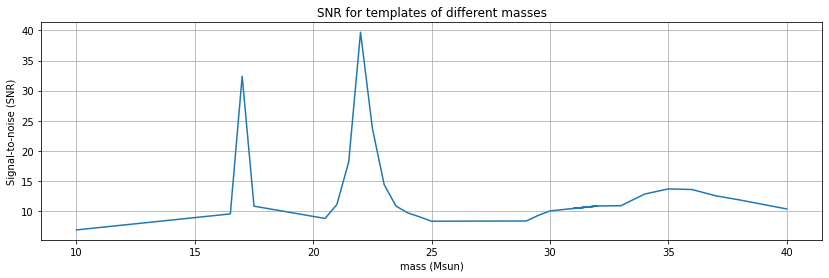

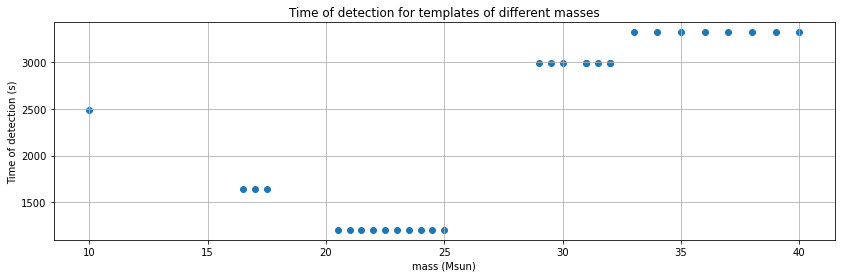

In [13]:
import pylab
%matplotlib inline

m_H1=[10.0, 16.5, 17.0, 17.5, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 29.0, 29.5, 30.0, 31.0, 31.5, 32.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
s_H1=[6.870953418426634, 9.528067869876283, 32.38142857790623, 10.815447656993964, 8.774532475179756, 11.085923600008103, 18.136933448966463, 39.691721000346995, 23.768212989860313, 14.367890590956755, 10.819184210021263, 9.69185619558298, 9.032050505928849, 8.314740860974315, 8.353597248588105, 9.268629370714223, 10.01986517241529, 10.440770773918787, 10.629767637570206, 10.843135009764772, 10.440770773918835, 10.843135009764811, 10.890389596399535, 12.822202694508045, 13.681677513361022, 13.578986328998454, 12.539178729158206, 11.858658874651068, 11.105951253620521, 10.358208274114746]
t_H1=[2483.96875, 1638.1591796875, 1638.158203125, 1638.15771484375, 1204.71142578125, 1204.7109375, 1204.7109375, 1204.71044921875, 1204.7099609375, 1204.70947265625, 1204.70947265625, 1204.708984375, 1204.708984375, 1204.70849609375, 2995.34423828125, 2995.34375, 2995.34375, 2995.34326171875, 2995.3427734375, 2995.34228515625, 2995.34326171875, 2995.34228515625, 3319.2548828125, 3319.25439453125, 3319.25390625, 3319.25341796875, 3319.25341796875, 3319.2529296875, 3319.25244140625, 3319.251953125]

pylab.figure(figsize=[14, 4])
pylab.plot(m_H1, s_H1, label='H1')
pylab.title('SNR for templates of different masses')
pylab.grid()
pylab.xlabel('mass (Msun)')
pylab.ylabel('Signal-to-noise (SNR)')
pylab.show()

pylab.figure(figsize=[14, 4])
pylab.scatter(m_H1, t_H1, label='H1')
pylab.title('Time of detection for templates of different masses')
pylab.grid()
pylab.xlabel('mass (Msun)')
pylab.ylabel('Time of detection (s)')
pylab.show()

### H1

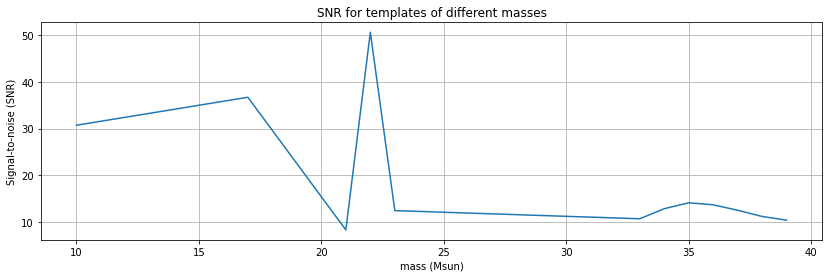

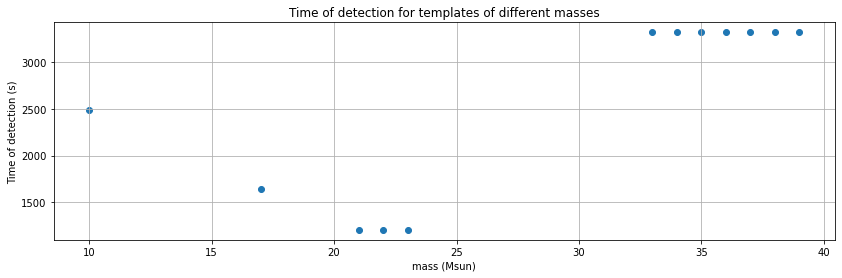

In [14]:
import pylab
%matplotlib inline

m_H1=[10.0, 17.0, 21.0, 22.0, 23.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0]
s_H1=[30.72818445103826, 36.71555801915532, 8.328274750533325, 50.630937653109356, 12.460128037159748, 10.71552486710834, 12.863662306610388, 14.141076640358367, 13.702380416369891, 12.537134849034107, 11.208312717781832, 10.410860844624809]
t_H1=[2483.96875, 1638.158203125, 1204.71142578125, 1204.71044921875, 1204.70947265625, 3319.2548828125, 3319.25439453125, 3319.25341796875, 3319.2529296875, 3319.25244140625, 3319.251953125, 3319.251953125]

pylab.figure(figsize=[14, 4])
pylab.plot(m_H1, s_H1, label='L1')
pylab.title('SNR for templates of different masses')
pylab.grid()
pylab.xlabel('mass (Msun)')
pylab.ylabel('Signal-to-noise (SNR)')
pylab.show()

pylab.figure(figsize=[14, 4])
pylab.scatter(m_H1, t_H1, label='L1')
pylab.title('Time of detection for templates of different masses')
pylab.grid()
pylab.xlabel('mass (Msun)')
pylab.ylabel('Time of detection (s)')
pylab.show()